In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
class HEDataset(Dataset):
    def __init__(self, images_file_path, labels_file_path, transform=None):
        self.images_file_path = images_file_path
        self.labels_file_path = labels_file_path
        self.transform = transform

        # Load the file to check the shape of the dataset
        self._print_dataset_shapes()

    def _print_dataset_shapes(self):
        with h5py.File(self.images_file_path, 'r') as images_file:
            # Assuming you want to know the shape of the first image dataset
            first_image_key = list(images_file.keys())[0]
            image_shape = images_file[first_image_key].shape
            print(f"Image dataset shape: {image_shape}")
            self.length = image_shape[0]

        with h5py.File(self.labels_file_path, 'r') as labels_file:
            # Assuming you want to know the shape of the first label dataset
            first_label_key = list(labels_file.keys())[0]
            label_shape = labels_file[first_label_key].shape
            print(f"Label dataset shape: {label_shape}")

            if label_shape[0] != self.length:
                print("BAD: make error. Dataset x and y sizes do not match")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.images_file_path, 'r') as images_file:
            first_image_key = list(images_file.keys())[0]
            image_data = images_file[first_image_key][idx]

        with h5py.File(self.labels_file_path, 'r') as labels_file:
            first_label_key = list(labels_file.keys())[0]
            label_data = labels_file[first_label_key][idx]

        if self.transform:
            image_data = self.transform(image_data)

        return image_data, label_data

# # Example usage (assuming you have appropriate transforms set)
# dataset = HEDataset('path_to_your_images_h5_file.h5', 'path_to_your_labels_h5_file.h5', transform=None)

# # The shapes of the first image and label in the dataset will be printed upon initialization.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%ls

camelyonpatch_level_2_split_test_meta.csv      camelyonpatch_level_2_split_train_x.h5
camelyonpatch_level_2_split_test_x.h5          camelyonpatch_level_2_split_train_y.h5
camelyonpatch_level_2_split_test_y.h5          camelyonpatch_level_2_split_valid_meta.csv
camelyonpatch_level_2_split_train_mask.h5      camelyonpatch_level_2_split_valid_x.h5
camelyonpatch_level_2_split_train_meta.csv     camelyonpatch_level_2_split_valid_y.h5
camelyonpatch_level_2_split_train_meta.gsheet


In [ ]:
#move to the project directory
%cd MyDrive/Senior/ACV/Project/

[Errno 2] No such file or directory: 'MyDrive/Senior/ACV/Project/'
/content/drive/MyDrive/Senior/ACV/Project/pcam


In [ ]:
%cd pcam

[Errno 2] No such file or directory: 'pcam'
/content/drive/MyDrive/Senior/ACV/Project/pcam


In [ ]:
test_x = 'camelyonpatch_level_2_split_test_x.h5'
test_y = 'camelyonpatch_level_2_split_test_y.h5'
train_mask = 'camelyonpatch_level_2_split_train_mask.h5'
train_x = 'camelyonpatch_level_2_split_train_x.h5'
train_y = 'camelyonpatch_level_2_split_train_y.h5'
valid_x = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y = 'camelyonpatch_level_2_split_valid_y.h5'

In [ ]:
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
# ])
BATCH_SIZE = 64

print("test:")
test_dataset = HEDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(test_dataloader)) ## len(test_dataset)//BATCH_SIZE

print("train:")
train_dataset = HEDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataloader)) ## len(train_dataset)//BATCH_SIZE
print('val')
validation_dataset = HEDataset(valid_x, valid_y)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(validation_dataloader)) ## len(validation_dataset)//BATCH_SIZE

test:
Image dataset shape: (32768, 96, 96, 3)
Label dataset shape: (32768, 1, 1, 1)
512
train:
Image dataset shape: (262144, 96, 96, 3)
Label dataset shape: (262144, 1, 1, 1)
4096
val
Image dataset shape: (32768, 96, 96, 3)
Label dataset shape: (32768, 1, 1, 1)
512


In [ ]:
#Load in metadata

train_csv = 'camelyonpatch_level_2_split_train_meta.csv'
test_csv = 'camelyonpatch_level_2_split_test_meta.csv'
valid_csv = 'camelyonpatch_level_2_split_valid_meta.csv'

train_meta = pd.read_csv(train_csv)
test_meta = pd.read_csv(test_csv)
val_meta = pd.read_csv(valid_csv)

In [ ]:
def convert_to_int(df):
    df["tumor_patch"] = df["tumor_patch"].astype(int)
    df["center_tumor_patch"] = df["center_tumor_patch"].astype(int)
    return df

train_meta = convert_to_int(train_meta)
test_meta = convert_to_int(test_meta)
val_meta = convert_to_int(val_meta)

In [ ]:
print("Tumor Patch Frequencies")
print("Train:\n",train_meta['tumor_patch'].value_counts())
print("Test:\n",test_meta['tumor_patch'].value_counts())
print("Validation:\n",val_meta['tumor_patch'].value_counts())

Tumor Patch Frequencies
Train:
 1    131745
0    130399
Name: tumor_patch, dtype: int64
Test:
 1    16474
0    16294
Name: tumor_patch, dtype: int64
Validation:
 1    16458
0    16310
Name: tumor_patch, dtype: int64


In [ ]:
print("Center Tumor Patch Frequencies")
print("Train:\n",train_meta['center_tumor_patch'].value_counts())
print("Test:\n",test_meta['center_tumor_patch'].value_counts())
print("Validation:\n",val_meta['center_tumor_patch'].value_counts())

Center Tumor Patch Frequencies
Train:
 0    131072
1    131072
Name: center_tumor_patch, dtype: int64
Test:
 0    16391
1    16377
Name: center_tumor_patch, dtype: int64
Validation:
 0    16399
1    16369
Name: center_tumor_patch, dtype: int64


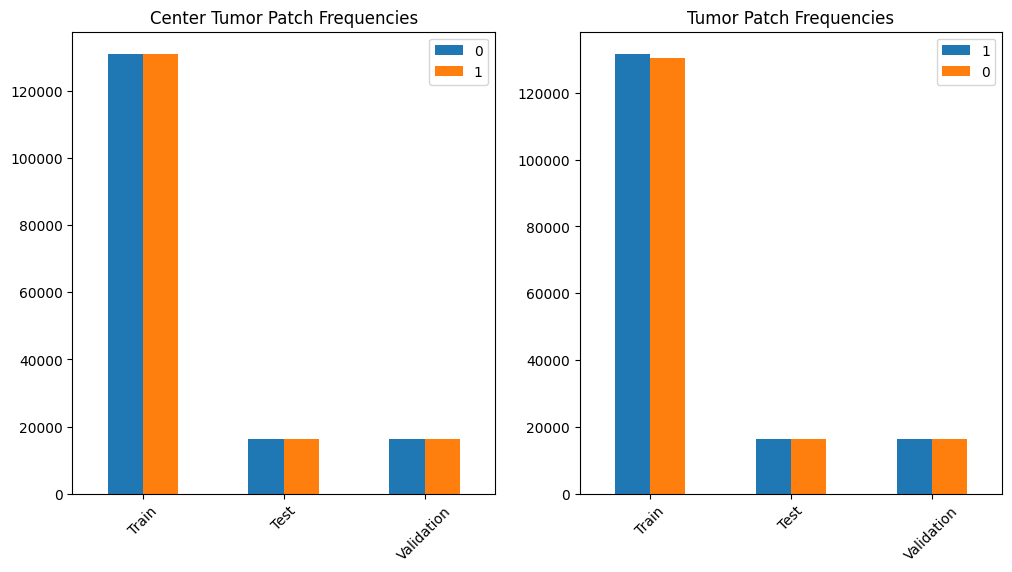

In [ ]:
#display counts of labels in train, validation and test data
import pandas as pd
import matplotlib.pyplot as plt


# Calculate frequencies
train_freq_center = train_meta['center_tumor_patch'].value_counts()
test_freq_center = test_meta['center_tumor_patch'].value_counts()
validation_freq_center = val_meta['center_tumor_patch'].value_counts()

train_freq = train_meta['tumor_patch'].value_counts()
test_freq = test_meta['tumor_patch'].value_counts()
val_freq = val_meta['tumor_patch'].value_counts()

# Prepare data for plotting
plot_data_center = pd.concat([train_freq_center, test_freq_center, validation_freq_center], keys=['Train', 'Test', 'Validation'], axis=1)
plot_data = pd.concat([train_freq, test_freq, val_freq], keys=['Train', 'Test', 'Validation'], axis=1)
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_data_center.T.plot(kind='bar', ax=axes[0], title='Center Tumor Patch Frequencies', rot=45)
plot_data.T.plot(kind='bar', ax=axes[1], title='Tumor Patch Frequencies', rot=45)
# Show plot
plt.show()


***IMPORTANT*** note: CENTER TUMOR PATCH IS THE LABEL

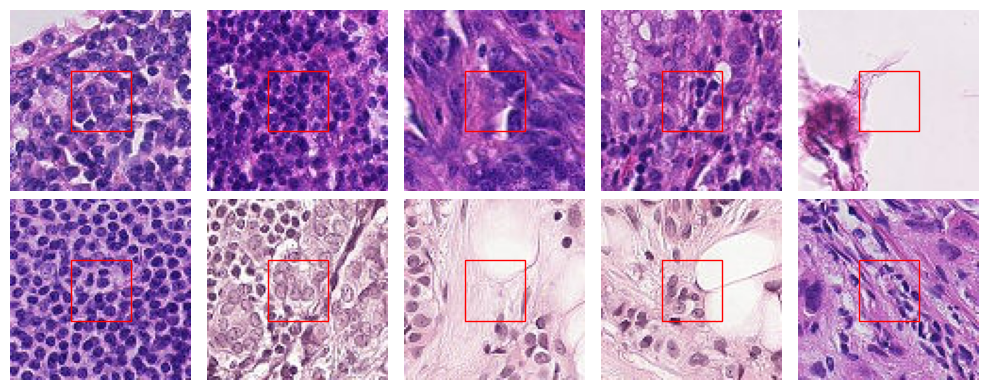

In [ ]:
train_labels = train_meta.to_numpy()
coord_x = 2
coord_y = 1
h = w = 32
x = 96//2
y = 96//2
locx = x - w/2
locy = y - h/2


fig, axes = plt.subplots(2,5, figsize = (10,4))
for i in range(10):
  axes[i%2,i%5].imshow(train_dataset[i][0])
  rect = patches.Rectangle((locx, locy), w, h, linewidth=1, edgecolor='r', facecolor='none')
  axes[i%2,i%5].axis('off')
  axes[i%2,i%5].add_patch(rect)
  print("")
plt.tight_layout()
plt.show()


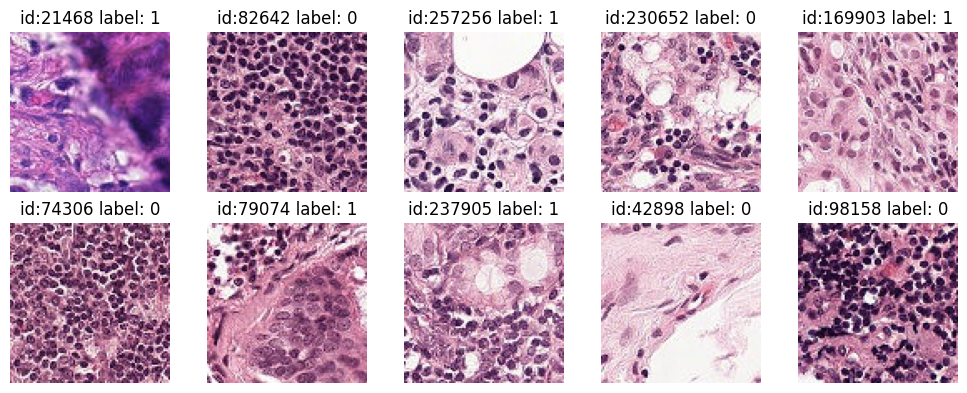

In [ ]:
import random

train_labels = train_meta.to_numpy()
h = w = 32
x = 96//2
y = 96//2
locx = x - w/2
locy = y - h/2

i_s = np.random.randint(0,len(train_labels),10)

fig, axes = plt.subplots(2,5, figsize = (10,4))
for e in range(10):
  i = i_s[e]
  axes[e%2,e%5].imshow(train_dataset[i][0])
  # rect = patches.Rectangle((locx, locy), w, h, linewidth=1, edgecolor='r', facecolor='none')
  axes[e%2,e%5].axis('off')
  # axes[e%2,e%5].add_patch(rect)
  t = 'id:' + str(i) + ' label: '+ str(train_labels[i][4])
  axes[e%2,e%5].set_title(t)
  print("")
plt.tight_layout()
plt.show()


A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image. This is however not a requirement for the PCam benchmark.

In [ ]:
from PIL import Image
#the dataset only looks at whether the center 32x32 region has metastatic tissue, so we want to crop the image accordingly
def crop_images(image):
    square_length = 32
    return image.crop((square_length, square_length, square_length, square_length))

for image in train_dataset:
  image = crop_images(image)

for image in validation_dataset:
  image = crop_images(image)

for image in test_dataset:
  image = crop_images(image)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding = 1)
        self.skip_connection = nn.Identity()
        if stride != 1 or in_channels != out_channels:
          #Use a Conv2d layer with kernel_size=1 to "resize" input
          self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)

    def forward(self, x):
        identity_x = self.skip_connection(x)
        identity_x = self.conv1(identity_x)
        identity_x = F.relu(identity_x)
        identity_x = self.conv2(identity_x)
        x = x + identity_x
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Need to crop the input to focus on the central 32x32 region
        # start off with 64 3x32x32 images
        # need to adjust the numbers for this dataset
        self.conv1 = nn.Conv2d(3, 32, 9) # 64x32x24x24
        self.pool1 = nn.MaxPool2d(2) # 64x32x12x12
        self.ResNet1 = ResNetBlock(32, 64, stride=2) # 64x64x12x12
        self.ResNet2 = ResNetBlock(64, 128) # 64x128x12x12

        self.conv2 = nn.Conv2d(128, 256, 5) # 64x256x8x8
        self.conv3 = nn.Conv2d(256, 256, 5) # 64x256x4x4
        self.pool2 = nn.MaxPool2d(2) # 64x256x2x2

        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(1024, 512)
        self.lin2 = nn.Linear(512, 100)
        self.lin3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.ResNet1(x)
        x = self.ResNet2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        return x

res_net = ResNet()

In [ ]:
def train_network(net, n_epochs=2):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i % 1000 == 0:
                print(f'Epoch={epoch + 1} Iter={i + 1:5d} Loss={loss.item():.3f}')
                running_loss = 0.0
    print('Finished Training')
    return net